In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import riskfolio as rp
from tqdm import tqdm

In [2]:
# df = pd.read_pickle(r"D:\Datasets\TwoSigmaDataSetBr_2022_03_04\Papertrade_br\models\MlpVarianceSwap\trained_model\model_MlpVarianceSwap_2022-03-03\full_market_data_final.pkl")
# df_test = pd.read_pickle(r"D:\Datasets\TwoSigmaDataSetBr_2022_03_04\Papertrade_br\models\MlpVarianceSwap\trained_model\model_MlpVarianceSwap_2022-03-03\df_test_mestrado.pkl")

In [3]:
def split_sequence(sequence, n_steps):
    list_subsequences = []
    empty_subsequence = [np.nan] * n_steps
    # Fill the initial subsequences with nan
    for i in range(min(n_steps, len(sequence))):
        list_subsequences.append(empty_subsequence)
    if len(sequence) <= n_steps:
        return list_subsequences
    # Fill the remaining subsequences
    for i in range(n_steps, len(sequence)):
        subsequence = sequence[i - n_steps:i]
        list_subsequences.append(subsequence)
    return list_subsequences

In [4]:
df = pd.read_pickle(r"D:\Datasets\TwoSigmaDataSetBr_2022_03_04\Papertrade_br\models\MlpVarianceSwap\trained_model\model_MlpVarianceSwap_2022-03-03\full_market_data_final.pkl")
df = df[['asset_identifier', 'date', 'close', 'universe', 'min_fin_volume']]
df.loc[:, 'ret'] = df.groupby('asset_identifier')['close'].pct_change()
df.loc[:, 'target'] = df.groupby('asset_identifier')['ret'].shift(-1)

df_test = pd.read_pickle(r"D:\Datasets\TwoSigmaDataSetBr_2022_03_04\Papertrade_br\models\MlpVarianceSwap\trained_model\model_MlpVarianceSwap_2022-03-03\df_test_mestrado.pkl")
df_test = df_test[['asset_identifier', 'date', 'yhat']]
df = df.merge(df_test, on = ['asset_identifier', 'date'], how = 'left')


In [5]:
n_steps = 60
return_columns = ['t_minus_{}'.format(n_steps - i) for i in range(n_steps)]

In [6]:
%%time
list_df = []
for asset, data in df.groupby('asset_identifier'):
    ret_shift_as_seq = split_sequence(data.loc[:, 'ret'].to_list(), n_steps)
    ret_shift_as_seq = pd.DataFrame(ret_shift_as_seq, index = data.index, columns = return_columns)
    data = data.join(ret_shift_as_seq)
    list_df.append(data)

Wall time: 4.83 s


In [7]:
df = pd.concat(list_df)
df.query("date > '2015-01-01' & universe", inplace = True)

In [8]:
df.loc[:, 'rank_pred']  = df.groupby('date')['yhat'].rank(pct = False, ascending = False)
df.loc[:, 'stdev'] = df[return_columns].std(axis = 1)
df = df.query("stdev != 0").dropna()

### Compute HPR Allocation

In [21]:
def rp_allocation(data, portfolio_parameters, return_columns):
    data = data[['asset_identifier'] + return_columns]
    Y = data.set_index('asset_identifier').T
    if 'inverse_vol' in portfolio_parameters:
        stdev = data.set_index('asset_identifier').std(axis = 1)
        w = 1/stdev
        w = w/w.sum()
        return w
    else:
        port = rp.HCPortfolio(returns=Y)
        w = port.optimization(**portfolio_parameters)
        return w['weights']

def compute_rp_allocations(df, return_columns, portfolio_parameters, steps_by_update = 10):
    list_df = []
    for i, (date, data) in tqdm(enumerate(df.groupby('date')), total=len(df['date'].unique())):
        data = data[['asset_identifier', 'date'] + return_columns].dropna()
        if i%steps_by_update == 0:
            weights = rp_allocation(data, portfolio_parameters, return_columns)
        data = data.set_index('asset_identifier')[['date']]
        data.loc[:, 'weights'] = weights
        list_df.append(data)
    df_weights = pd.concat(list_df).reset_index()
    return df_weights

def evaluate_rp_allocation(df, return_columns, portfolio_parameters, steps_by_update):
    df_weights = compute_rp_allocations(df, return_columns, portfolio_parameters, steps_by_update) 
    df_merge = df.merge(df_weights, on = ['asset_identifier', 'date'])

    #Debug
    df_merge.loc[:, 'stdev_rank'] = df_merge.groupby('date')['stdev'].rank(pct = True)
    weights_std_corr = df_merge[['stdev_rank', 'weights']].corr().iloc[0, 1]
    print(f'weights_std_corr: {weights_std_corr}')

    #Evaluate
    df_merge.eval("pnl = weights * target", inplace = True)

    pnl = df_merge.groupby('date')['pnl'].sum()
    sharpe = pnl.mean()/pnl.std() * 252**0.5

    pnl.cumsum().plot()
    print(f'sharpe: {sharpe}')
    return df_merge

In [10]:
%%time
portfolio_parameters = dict(model='HRP',
                            codependence = 'pearson',
                            rm = 'MV',
                            rf = 0,
                            linkage = 'single',
                            max_k = 10,
                            leaf_order = True)

Wall time: 0 ns


100%|██████████████████████████████████████████████████████████████████████████████| 1771/1771 [01:50<00:00, 15.98it/s]


weights_std_corr: -0.25223435167333547
sharpe: 0.4951946429703976
Wall time: 1min 51s


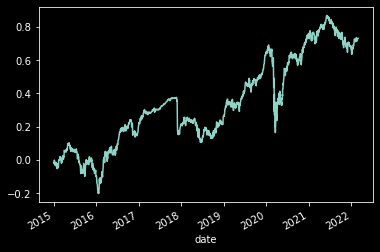

In [14]:
steps_by_update = 10
_ = evaluate_rp_allocation(df, return_columns, portfolio_parameters, steps_by_update)

100%|██████████████████████████████████████████████████████████████████████████████| 1771/1771 [03:17<00:00,  8.97it/s]


weights_std_corr: -0.5516537055255089
sharpe: 0.9359545250304856
Wall time: 3min 18s


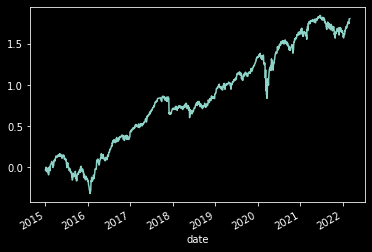

In [18]:
%%time
steps_by_update = 1
_ = evaluate_rp_allocation(df.query("rank_pred < 20"), return_columns, portfolio_parameters, steps_by_update)

In [19]:
%%time
portfolio_parameters = dict(inverse_vol=True)

Wall time: 0 ns


100%|█████████████████████████████████████████████████████████████████████████████| 1771/1771 [00:07<00:00, 240.30it/s]


weights_std_corr: -0.6457788563474818
sharpe: 0.690767745729287


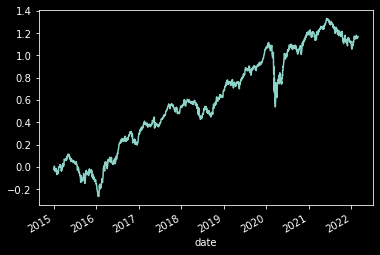

In [16]:
steps_by_update = 10
_ = evaluate_rp_allocation(df, return_columns, portfolio_parameters, steps_by_update)

100%|█████████████████████████████████████████████████████████████████████████████| 1771/1771 [00:09<00:00, 184.66it/s]


weights_std_corr: -0.698007931766652
sharpe: 0.9453573799765881
Wall time: 10.5 s


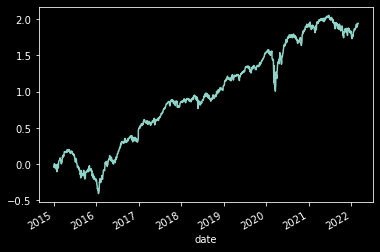

In [22]:
%%time
steps_by_update = 1
_ = evaluate_rp_allocation(df.query("rank_pred < 20"), return_columns, portfolio_parameters, steps_by_update)

### Allocations with custom  mu

<hr />

### Compute covariance matrices

In [4]:
def split_sequence(sequence, n_steps, drop_zeros = True):
    list_subsequences = []
    empty_subsequence = [np.nan] * n_steps
    # Fill the initial subsequences with nan
    for i in range(min(n_steps, len(sequence))):
        list_subsequences.append(empty_subsequence)
    if len(sequence) <= n_steps:
        return list_subsequences
    # Fill the remaining subsequences
    for i in range(n_steps, len(sequence)):
        subsequence = sequence[i - n_steps:i]
        if len(np.unique(subsequence) == 1) & drop_zeros:
            subsequence = empty_subsequence
        list_subsequences.append(subsequence)
    return list_subsequences

In [5]:
%%time
n_steps = 60
columns = ['t_minus_{}'.format(n_steps - i) for i in range(n_steps)]
list_df = []
for asset, data in df.groupby('asset_identifier'):
    ret_shift_as_seq = split_sequence(data.loc[:, 'ret'].to_list(), n_steps)
    ret_shift_as_seq = pd.DataFrame(ret_shift_as_seq, index = data.index, columns = columns)
    data = data.join(ret_shift_as_seq)
    list_df.append(data)
df = pd.concat(list_df)
df = df[['asset_identifier', 'date'] + columns].query("date > '2007-12-31'").reset_index(drop = True)

Wall time: 15.1 s


In [6]:
dict_covariances_by_date = {}

In [7]:
%%time
for date, data in df.groupby('date'):
    cov = data.drop(columns = ['date']).set_index('asset_identifier').T.cov()
    dict_covariances_by_date[date] = cov

Wall time: 11.1 s


<hr />